In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cuda


In [4]:
words = open("names.txt", "r").read().splitlines()

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

In [6]:
vocab_size = len(stoi)
word_count = len(words)
print(f"{vocab_size=}")
print(f"{word_count=}")

vocab_size=27
word_count=32033


In [7]:
block_size = 3


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
def cmp(s, dt: torch.Tensor, t: torch.Tensor):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}"
    )

In [11]:
n_emb = 10
n_hidden = 64


g = torch.Generator(device=device).manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
w1 = (
    torch.randn((n_emb * block_size, 200), generator=g)
    * (5 / 3)
    / ((n_emb * block_size) ** 0.5)
)
# Can remove bias due ot batchnorm removing its effect
b1 = torch.randn(n_hidden, generator=g) * 0.1
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

bn_gain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bn_bias = torch.randn((1, n_hidden)) * 0.1

bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

params = [C, w1, b1, w2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

8217


In [9]:
# Batch Normalisation
"""
Dont want pre activation states to be too small so that the tanh isnt doing anything
Or too large so that the tanh saturates it too much
Want them to be roughly gaussian
BatchNorm makes the pre activation gaussian at initialisation

Dont want to always force pre activation to be gaussian wed like to allow nn to vary the dist depending on back prop (scale and shift)
Therefore during backprop we can change bn_bias and bn_gain

"""

'\nDont want pre activation states to be too small so that the tanh isnt doing anything\nOr too large so that the tanh saturates it too much\nWant them to be roughly gaussian\nBatchNorm makes the pre activation gaussian at initialisation\n\nDont want to always force pre activation to be gaussian wed like to allow nn to vary the dist depending on back prop (scale and shift)\nTherefore during backprop we can change bn_bias and bn_gain\n\n'

In [19]:
max_steps = 200000
batch_size = 32
lossi = []
best_loss = 0

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1

    # -----------BatchNormalisation Layer ----------------
    bn_meani = hpreact.mean(0, keepdim=True)
    bn_stdi = hpreact.std(0, keepdim=True)

    hpreact = bn_gain * (hpreact - bn_meani) / bn_stdi + bn_bias  # BATCHNORMALISATION

    with torch.no_grad():
        bn_mean_running = 0.999 + bn_mean_running + 0.001 * bn_meani
        bn_std_running = 0.999 + bn_std_running + 0.001 * bn_stdi

    # ----------Non Linearity ----------------

    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in params:
        p.grad = None
    loss.backward()

    # Update Parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")

    lossi.append(loss.log10().item())

      0/ 200000: 2.089463
  10000/ 200000: 1.902251
  20000/ 200000: 1.820950
  30000/ 200000: 2.015711
  40000/ 200000: 2.028321
  50000/ 200000: 2.132854
  60000/ 200000: 2.058287
  70000/ 200000: 2.421978
  80000/ 200000: 2.029055
  90000/ 200000: 1.936962
 100000/ 200000: 2.259862
 110000/ 200000: 2.265439
 120000/ 200000: 1.963771
 130000/ 200000: 2.417619
 140000/ 200000: 2.054292
 150000/ 200000: 2.411887
 160000/ 200000: 2.472137
 170000/ 200000: 2.471863
 180000/ 200000: 1.813348
 190000/ 200000: 2.029222


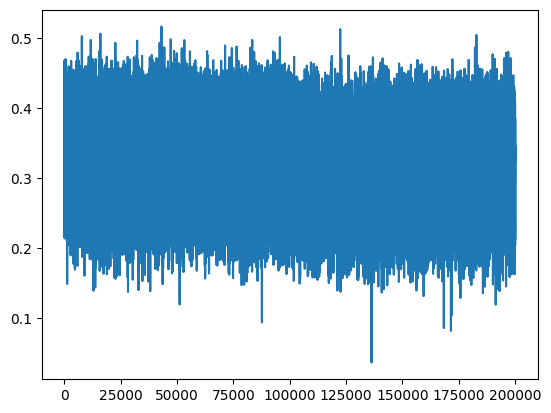

In [20]:
plt.plot([i for i in range(max_steps)], lossi);

In [21]:
# Calibrate the batch norm at the end of training to use during inference time
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    bn_mean = hpreact.mean(0, keepdim=True)
    bn_std = hpreact.std(0, keepdim=True)

In [22]:
@torch.no_grad()  # Decorator disables gradient tracking
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "test": (Xte, Yte), "val": (Xdev, Ydev)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    hpreact = bn_gain * (hpreact - bn_mean) / bn_std + bn_bias  # BATCHNORMALISATION
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("test")
split_loss("val")

train 2.0467939376831055
test 2.097883462905884
val 2.1004958152770996


In [29]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ w1 + b1
        hpreact = bn_gain * (hpreact - bn_mean) / bn_std + bn_bias  # BATCHNORMALISATION
        h = torch.tanh(hpreact)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

claurihiry.
pieaa.
holaviana.
chutie.
elystis.
orteygh.
marius.
san.
ayra.
terson.
karise.
kalistan.
davaltev.
kaileya.
ahlina.
kamo.
loren.
josalif.
zade.
colves.


In [14]:
# No changes
# train 2.1260766983032227
# test 2.171398162841797
# val 2.1688480377197266

# 0.1x the w2 and b2 t = 4m.15s
# train 2.0698041915893555
# test 2.133720874786377
# val 2.1256227493286133

# 0.1x the w1 and b1
# train 2.0504839420318604
# test 2.1084134578704834
# val 2.11212158203125

# BatchNorm
# train 2.0352141857147217
# test 2.0920584201812744
# val 2.0940141677856445
